In [ ]:
#Autor: Jhonatan Martinez

In [51]:
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from scipy.signal import savgol_filter
import seaborn as sns
from pyproj import Geod

#instala las bibliotecas necesarias 

In [ ]:
#lo que yo hago es que del dem extraigo las curvas de nivel y lo uso como gdf para operaciones espacialescon su marco, es mcuho mas facil con geopandas, fiona etc

Descargando
Archivo guardado: ejemplo.tif


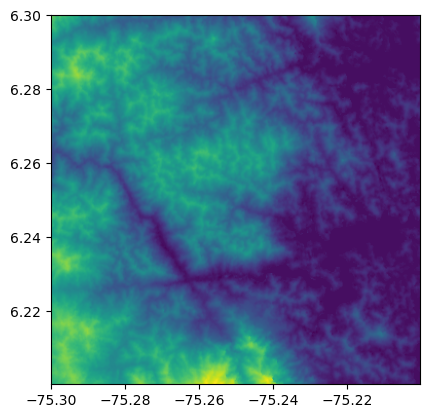

In [1]:
#reciclado de otro tutorial
import os
import requests
import rasterio as rio
from rasterio.plot import show

# Definir las coordenadas del área de interés y el tipo de DEM
bounds = bounds = (-75.3, 6.2, -75.2, 6.3)  # Coordenadas para Medellin en crs 4326 (Oeste, Sur, Este, Norte)
demtype = "SRTMGL1"  # Tipo de DEM: "SRTMGL3", "AW3D30", etc.

# URL base de la API de OpenTopography
base_url = "https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff&API_Key={}"

# Tu clave de API
api_key = "aquivatuclavedeapientrecomillasporsupuestovisitalapaginadeopentopoparaobtenerla"
#https://portal.opentopography.org visita esa paginapara obtener tu clave api
# Función para descargar el DEM
def get_ot_globaldem(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = f"{demtype}_DEM.tif"  # Nombre predeterminado si no se proporciona
    if not os.path.exists(out_fn):
        url = base_url.format(demtype, *bounds, api_key)
        print(f"Descargando")
        response = requests.get(url)
        if response.status_code == 200:
            with open(out_fn, 'wb') as f:
                f.write(response.content)
            print(f"Archivo guardado: {out_fn}")
        else:
            print(f"Error en la descarga. Código de estado: {response.status_code}")
            print(f"Mensaje de error: {response.text}")
            return None
    return out_fn

# Puedes especificar el nombre del archivo aquí
output_file_name = r"ejemplo.tif" 

# Descargar el DEM
output_file = get_ot_globaldem(demtype, bounds, out_fn=output_file_name)

# Verificar si el archivo fue descargado correctamente
if output_file is None or not os.path.exists(output_file):
    raise FileNotFoundError("El archivo DEM no pudo ser descargado. Verifica los parámetros o la clave API.")

# Visualizar el DEM
with rio.open(output_file) as src:
    show(src)

Leyendo el raster...
Estadísticas del raster: Min=1864.0, Max=2319.0
Generando coordenadas...
Generando curvas de nivel...
Extrayendo geometrías de las curvas...


C:\Users\Janus\AppData\Local\Temp\ipykernel_13600\2229174712.py:72: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for level, collection in zip(contour_set.levels, contour_set.collections):


Creando GeoDataFrame...
Guardando curvas de nivel en curvas de ejemplo.shp...
Proceso completado.


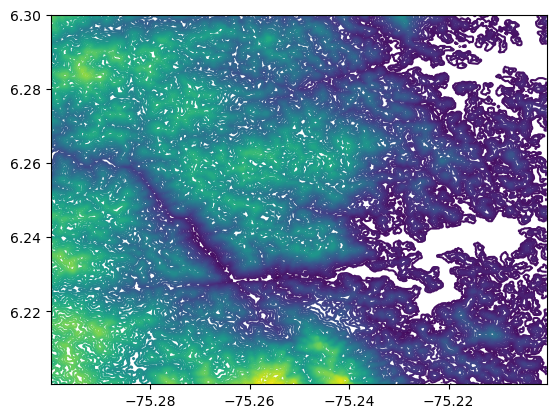

In [3]:
import os
import numpy as np
import rasterio
from shapely.geometry import LineString
import geopandas as gpd
import matplotlib.pyplot as plt
import dask.array as da
#dask es para procesadores con algo de recursos, visita mi github hay un tutorial de la forma tradicional
#https://github.com/yoniton
# Ruta del archivo raster y gdf de salida
raster_path = output_file_name
output_path = r"curvas de ejemplo.shp"

# Parámetros para las curvas de nivel
contour_interval = 10

# Leer el archivo raster con dask para procesamiento paralelo
print("Leyendo el raster...")
with rasterio.open(raster_path) as src:
    raster_data = src.read(1)  # Leer la banda de elevación
    transform = src.transform  # Transformación para coordenadas
    nodata = src.nodata  # Valor nodata del raster
    crs = src.crs  # Sistema de coordenadas
    
    # Convertir a array dask para procesamiento paralelo
    raster_data = da.from_array(raster_data, chunks=(1024, 1024))

    # Reemplazar valores nodata por NaN
    if nodata is not None:
        raster_data = da.where(raster_data == nodata, np.nan, raster_data)

# Verificar estadísticas en paralelo
min_elev = da.nanmin(raster_data).compute()
max_elev = da.nanmax(raster_data).compute()
print(f"Estadísticas del raster: Min={min_elev}, Max={max_elev}")

# Crear una cuadrícula de coordenadas
print("Generando coordenadas...")
height, width = raster_data.shape
x_coords = np.arange(width)
y_coords = np.arange(height)
x_world, y_world = np.meshgrid(
    np.linspace(0, width - 1, width),
    np.linspace(0, height - 1, height)
)
x_world, y_world = rasterio.transform.xy(transform, y_world, x_world, offset="center")
x_world = np.array(x_world)
y_world = np.array(y_world)

# Generar los contornos con matplotlib
print("Generando curvas de nivel...")
levels = np.arange(min_elev, max_elev + contour_interval, contour_interval)
contour_set = plt.contour(x_world, y_world, raster_data.compute(), levels=levels)

# Extraer las curvas como geometrías con sus elevaciones
print("Extrayendo geometrías de las curvas...")
contour_lines = []
contour_elevations = []

# Límites del cuadro (calculando las coordenadas de las esquinas)
xmin, ymin = rasterio.transform.xy(transform, 0, 0)  # Esquina inferior izquierda
xmax, ymax = rasterio.transform.xy(transform, height-1, width-1)  # Esquina superior derecha

# Función para verificar intersección con líneas anteriores
def check_intersection(new_line, existing_lines):
    for line in existing_lines:
        if new_line.intersects(line):
            return True  # Si intersecta con alguna línea, devolver True
    return False  # Si no intersecta con ninguna, devolver False

# Iterar sobre los contornos y extraer los niveles de elevación
for level, collection in zip(contour_set.levels, contour_set.collections):
    for path in collection.get_paths():
        for coords in path.to_polygons():
            if len(coords) > 1:  # Evitar geometrías vacías
                coords_array = np.array(coords)  # Convertir a un array de numpy

                # Verificar si la línea cruza los bordes
                if (
                    np.any(coords_array[:, 0] == xmin) or
                    np.any(coords_array[:, 0] == xmax) or
                    np.any(coords_array[:, 1] == ymin) or
                    np.any(coords_array[:, 1] == ymax)
                ):
                    # Mantener la línea abierta en los bordes
                    line = LineString(coords_array[:-1])  # Eliminamos el último punto (en el borde)
                else:
                    line = LineString(coords_array)

                # Verificar intersección con líneas anteriores
                if not check_intersection(line, contour_lines):
                    contour_lines.append(line)
                    contour_elevations.append(level)  # Asociar el nivel actual a la geometría

# Crear un GeoDataFrame con las curvas de nivel
print("Creando GeoDataFrame...")
gdf = gpd.GeoDataFrame(
    {'elevation': contour_elevations, 'geometry': contour_lines},
    crs=crs.to_wkt()
)

# Exportar el GeoDataFrame como shapefile
print(f"Guardando curvas de nivel en {output_path}...")
gdf.to_file(output_path, driver="ESRI Shapefile")
print("Proceso completado.")
#Usa una versión de matplotlib anterior a la 10

In [5]:
dem_path=output_file_name
gdf_contour_path=output_path

In [79]:
def crear_perfil(dem_path, gdf_contour_path, angle=0, num_points=1000, desy=0, desx=0):
    gdf_contour = gpd.read_file(gdf_contour_path)

    def create_line_by_angle_from_gdf(gdf, angle, desx=0, desy=0):
        total_bounds = gdf.total_bounds
        xmin, ymin, xmax, ymax = total_bounds
        mid_x, mid_y = (xmin + xmax) / 2, (ymin + ymax) / 2
        length = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
        angle_rad = np.deg2rad(angle)
        dx, dy = length * np.cos(angle_rad), length * np.sin(angle_rad)

        if angle in [0, 180]:
            start_point = (xmin + desx, mid_y + desy) if angle == 0 else (xmax + desx, mid_y + desy)
            end_point = (xmax + desx, mid_y + desy) if angle == 0 else (xmin + desx, mid_y + desy)
        elif angle in [90, 270]:
            start_point = (mid_x + desx, ymin + desy) if angle == 90 else (mid_x + desx, ymax + desy)
            end_point = (mid_x + desx, ymax + desy) if angle == 90 else (mid_x + desy, ymin + desy)
        else:
            start_point = (mid_x - dx / 2 + desx, mid_y - dy / 2 + desy)
            end_point = (mid_x + dx / 2 + desx, mid_y + dy / 2 + desy)

        return LineString([start_point, end_point])
    #si ya tienes la linea solo saca lo anterior de la función y remplaza el objeto, a mi me gusta porque solo tengo que jugar con la rotación y translación
    profile_line = create_line_by_angle_from_gdf(gdf_contour, angle)

    def extract_elevation_profile(dem_path, line_geom, num_points):
        with rasterio.open(dem_path) as dem:
            line_length = line_geom.length
            line_points = [line_geom.interpolate(i / num_points, normalized=True) for i in range(num_points + 1)]

            coords = [(point.x, point.y) for point in line_points]

            elevations = np.array([val[0] for val in dem.sample(coords)])

            mask = (elevations <= 0) | (elevations == dem.nodata)
            if np.any(mask):
                elevations[mask] = np.interp(
                    np.flatnonzero(mask), 
                    np.flatnonzero(~mask), 
                    elevations[~mask]
                )

        return elevations, coords

    elevations, coords = extract_elevation_profile(dem_path, profile_line, num_points)
    
    geod = Geod(ellps="WGS84")
    
    def plotear_perfil(elevations):
        distances = [0]
        for i in range(1, len(coords)):
            _, _, dist = geod.inv(coords[i - 1][0], coords[i - 1][1], coords[i][0], coords[i][1])
            distances.append(distances[-1] + dist)

        smoothed_elevations = savgol_filter(elevations, window_length=20, polyorder=3)

        # Suavizar las elevaciones con un filtro de Savitzky-Golay (opcional) mas ventana suaviza mas el ruido topografico
        #el grado del polinomio auyuda a no perder tanto detalle
        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(30, 10))

        sns.lineplot(x=distances, y=smoothed_elevations, ax=ax, label='Topografía', color='black', linewidth=2)

        num_labels = 10  
        step = len(distances) // num_labels  
        xticks = distances[::step]  

        xticklabels = [
            f"{dist:.0f} m\n({coords[distances.index(dist)][0]:.3f}, {coords[distances.index(dist)][1]:.3f})"
            for dist in xticks
        ]

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=45, ha='right')

        ax.set_xlim([0, distances[-1]])
        ax.set_ylim([min(smoothed_elevations) - 50, max(smoothed_elevations) + 150])

        ax.set_title('Perfil Topográfico', fontsize=16)
        ax.set_xlabel('Distancia (m)', fontsize=12)
        ax.set_ylabel('Elevación (m)', fontsize=12)
        plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
        plt.show()

    plotear_perfil(elevations)


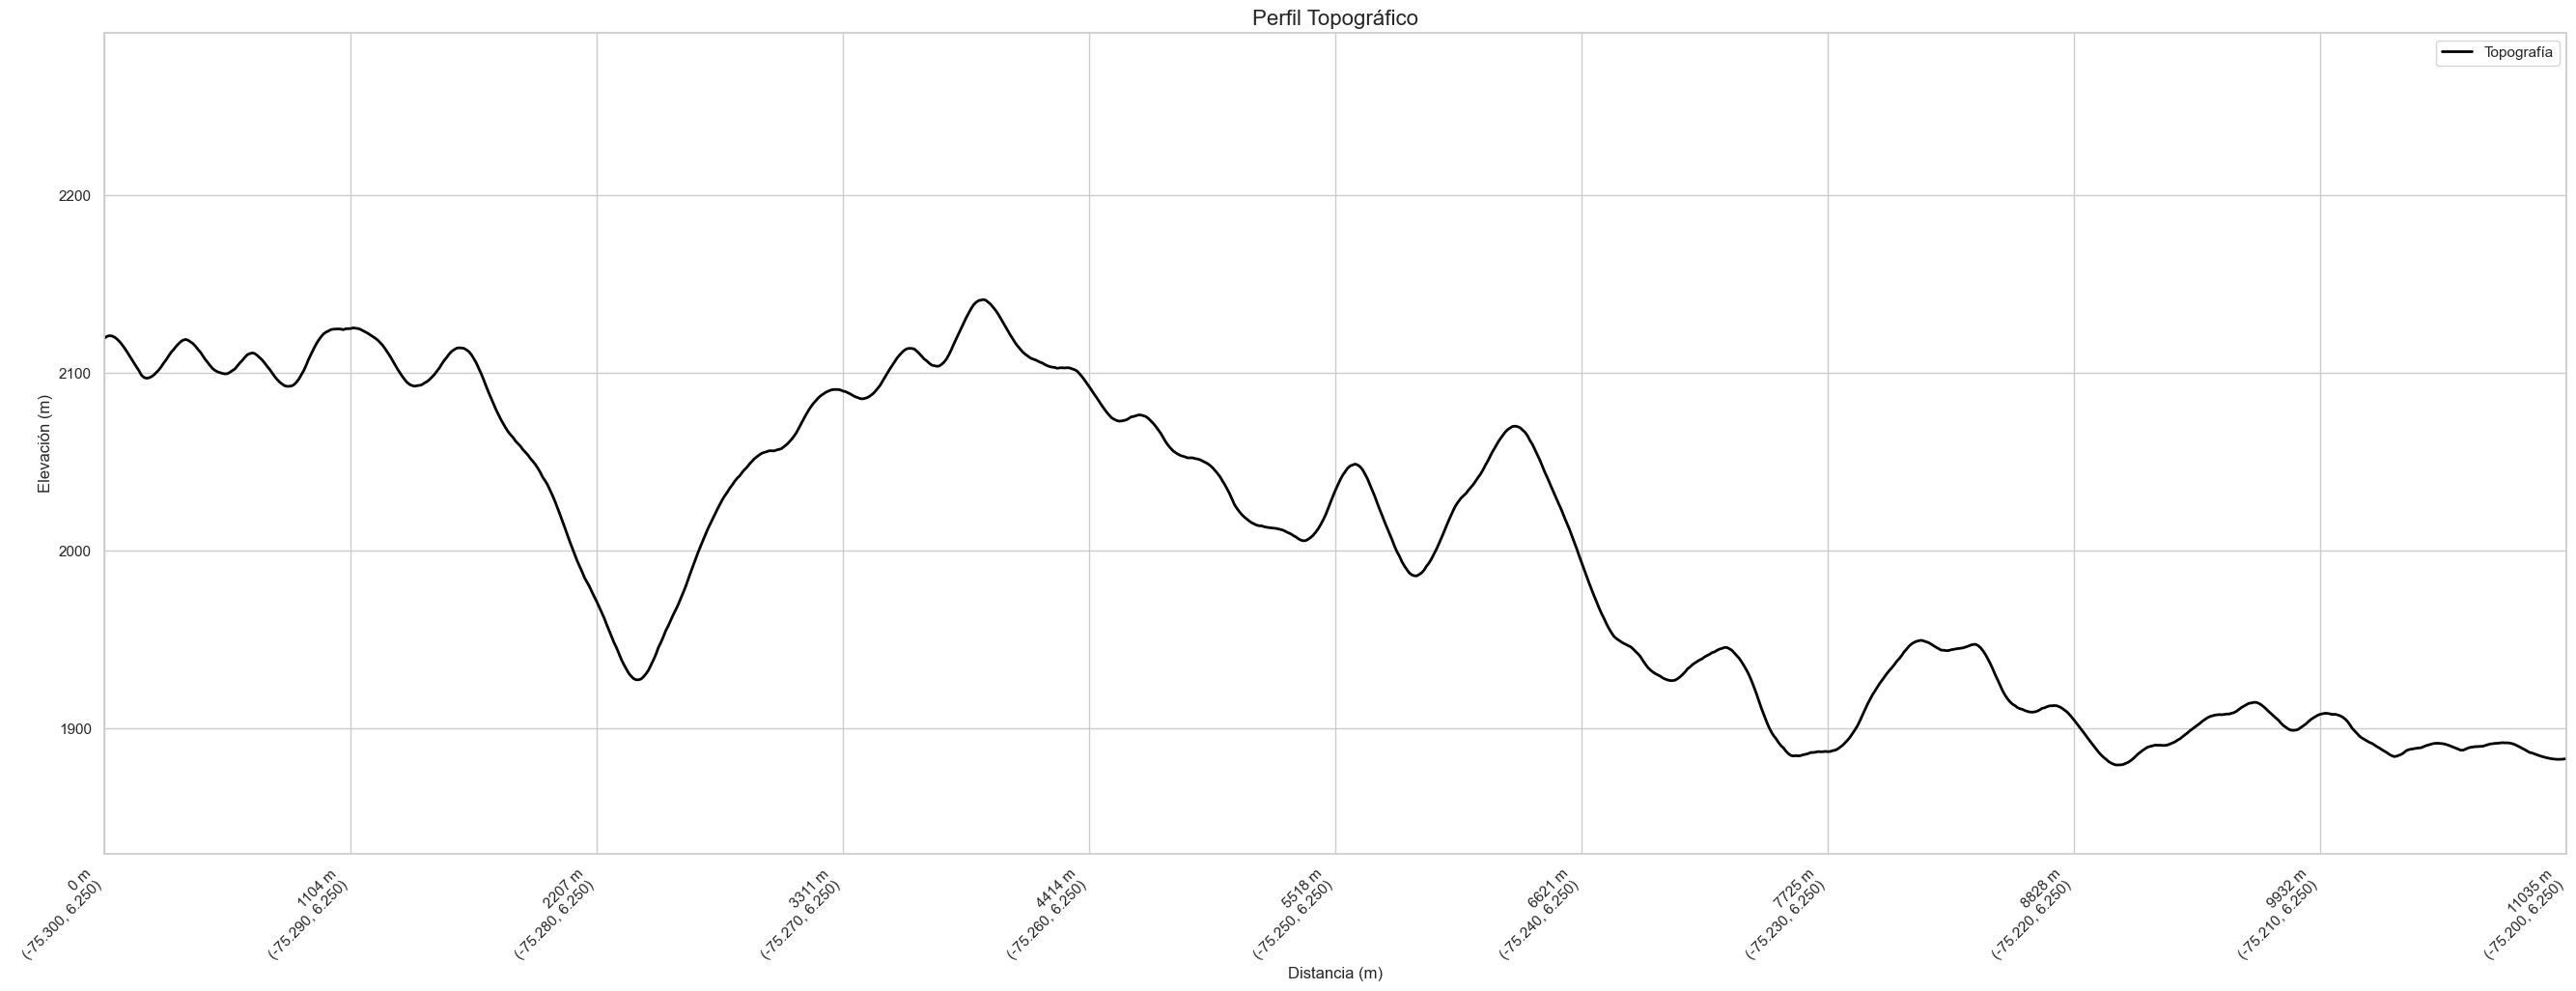

In [77]:
crear_perfil(dem_path, gdf_contour_path, angle=0)
#cambié el suavizado a 30

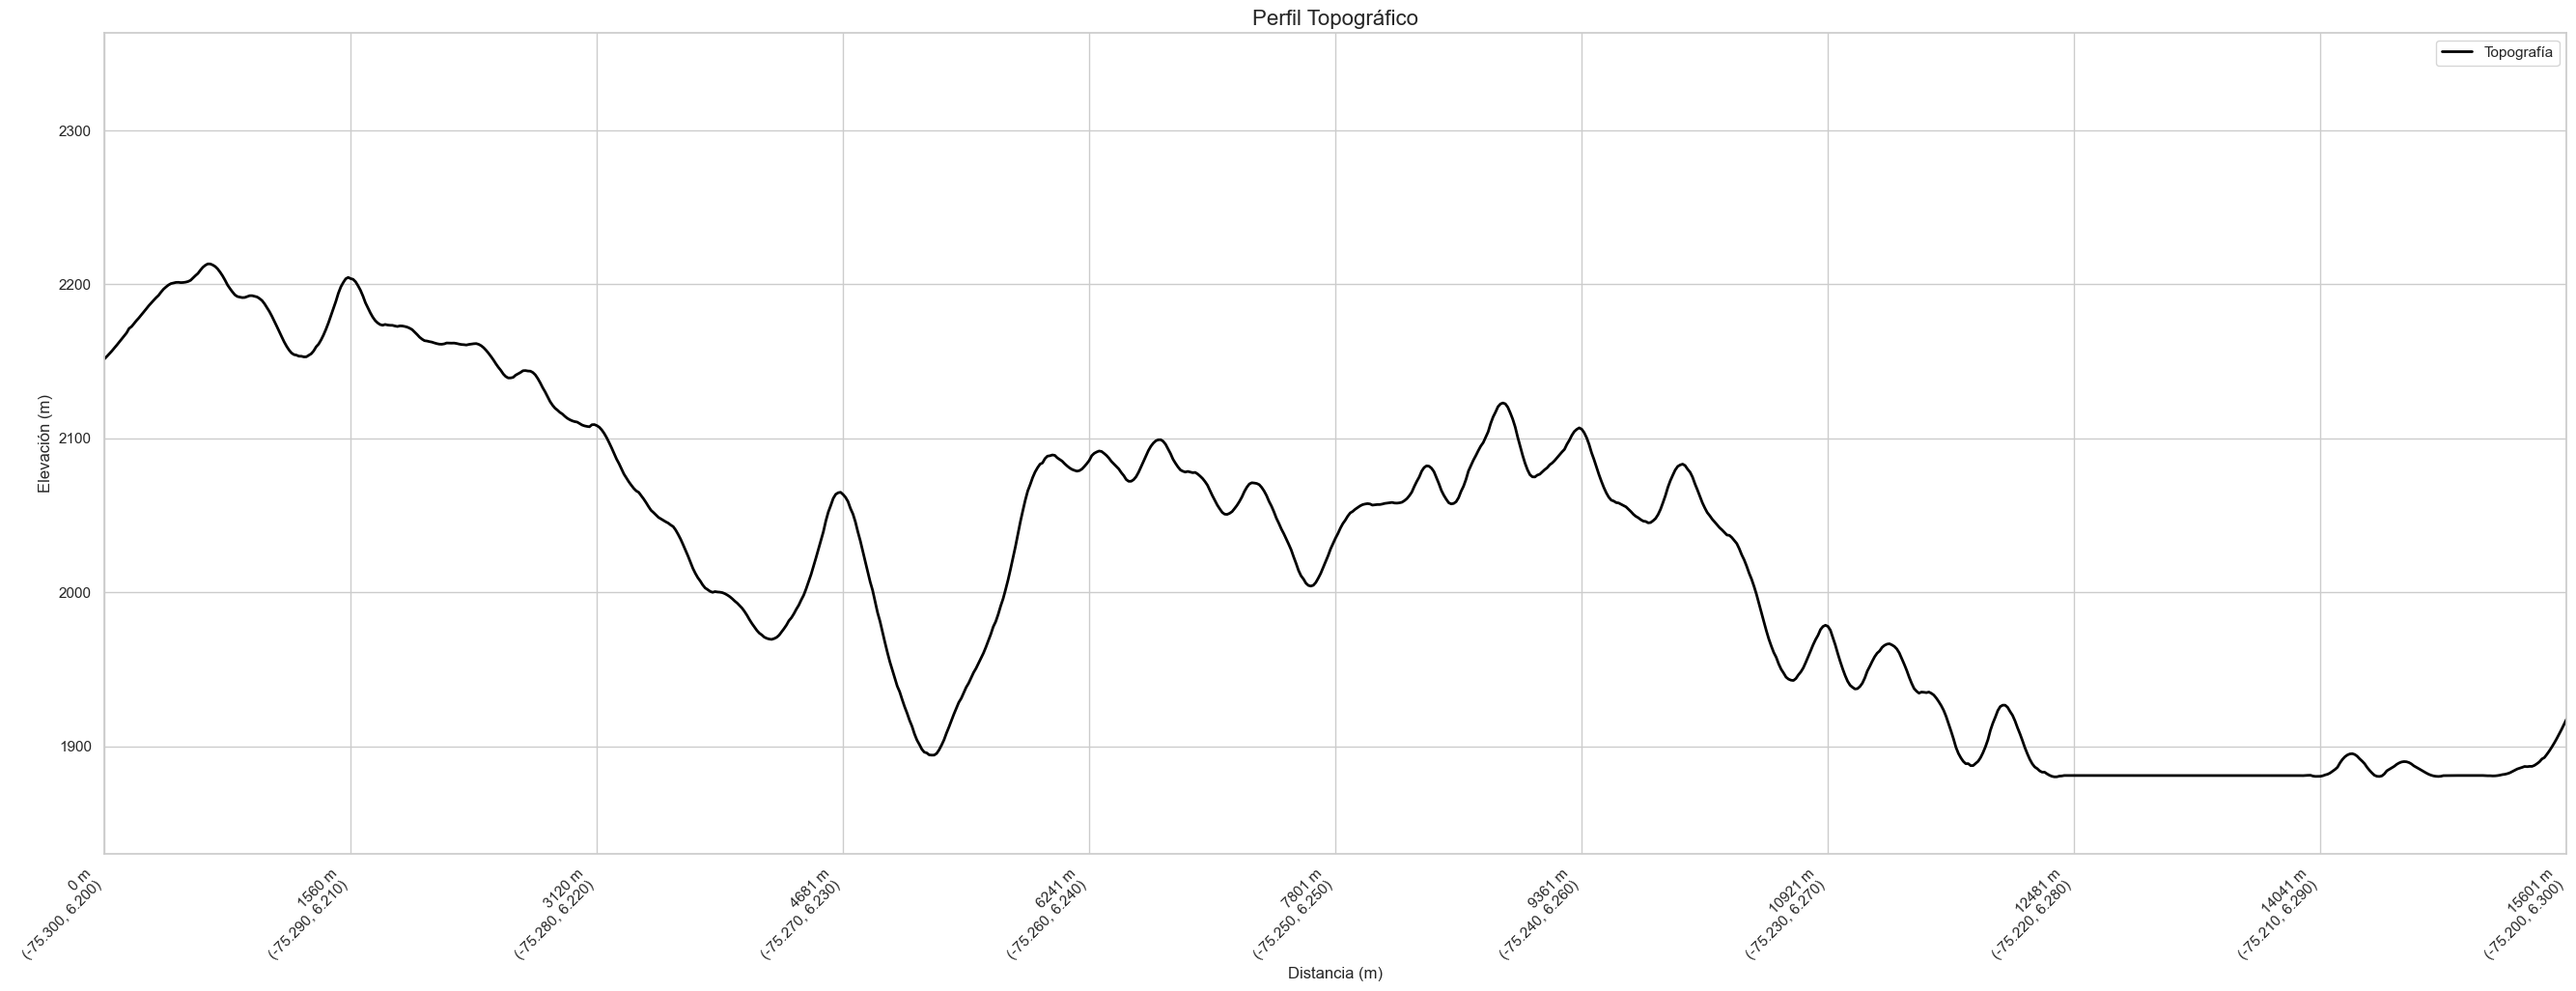

In [81]:
crear_perfil(dem_path, gdf_contour_path, angle=45)
#cambié el suavizado a 20

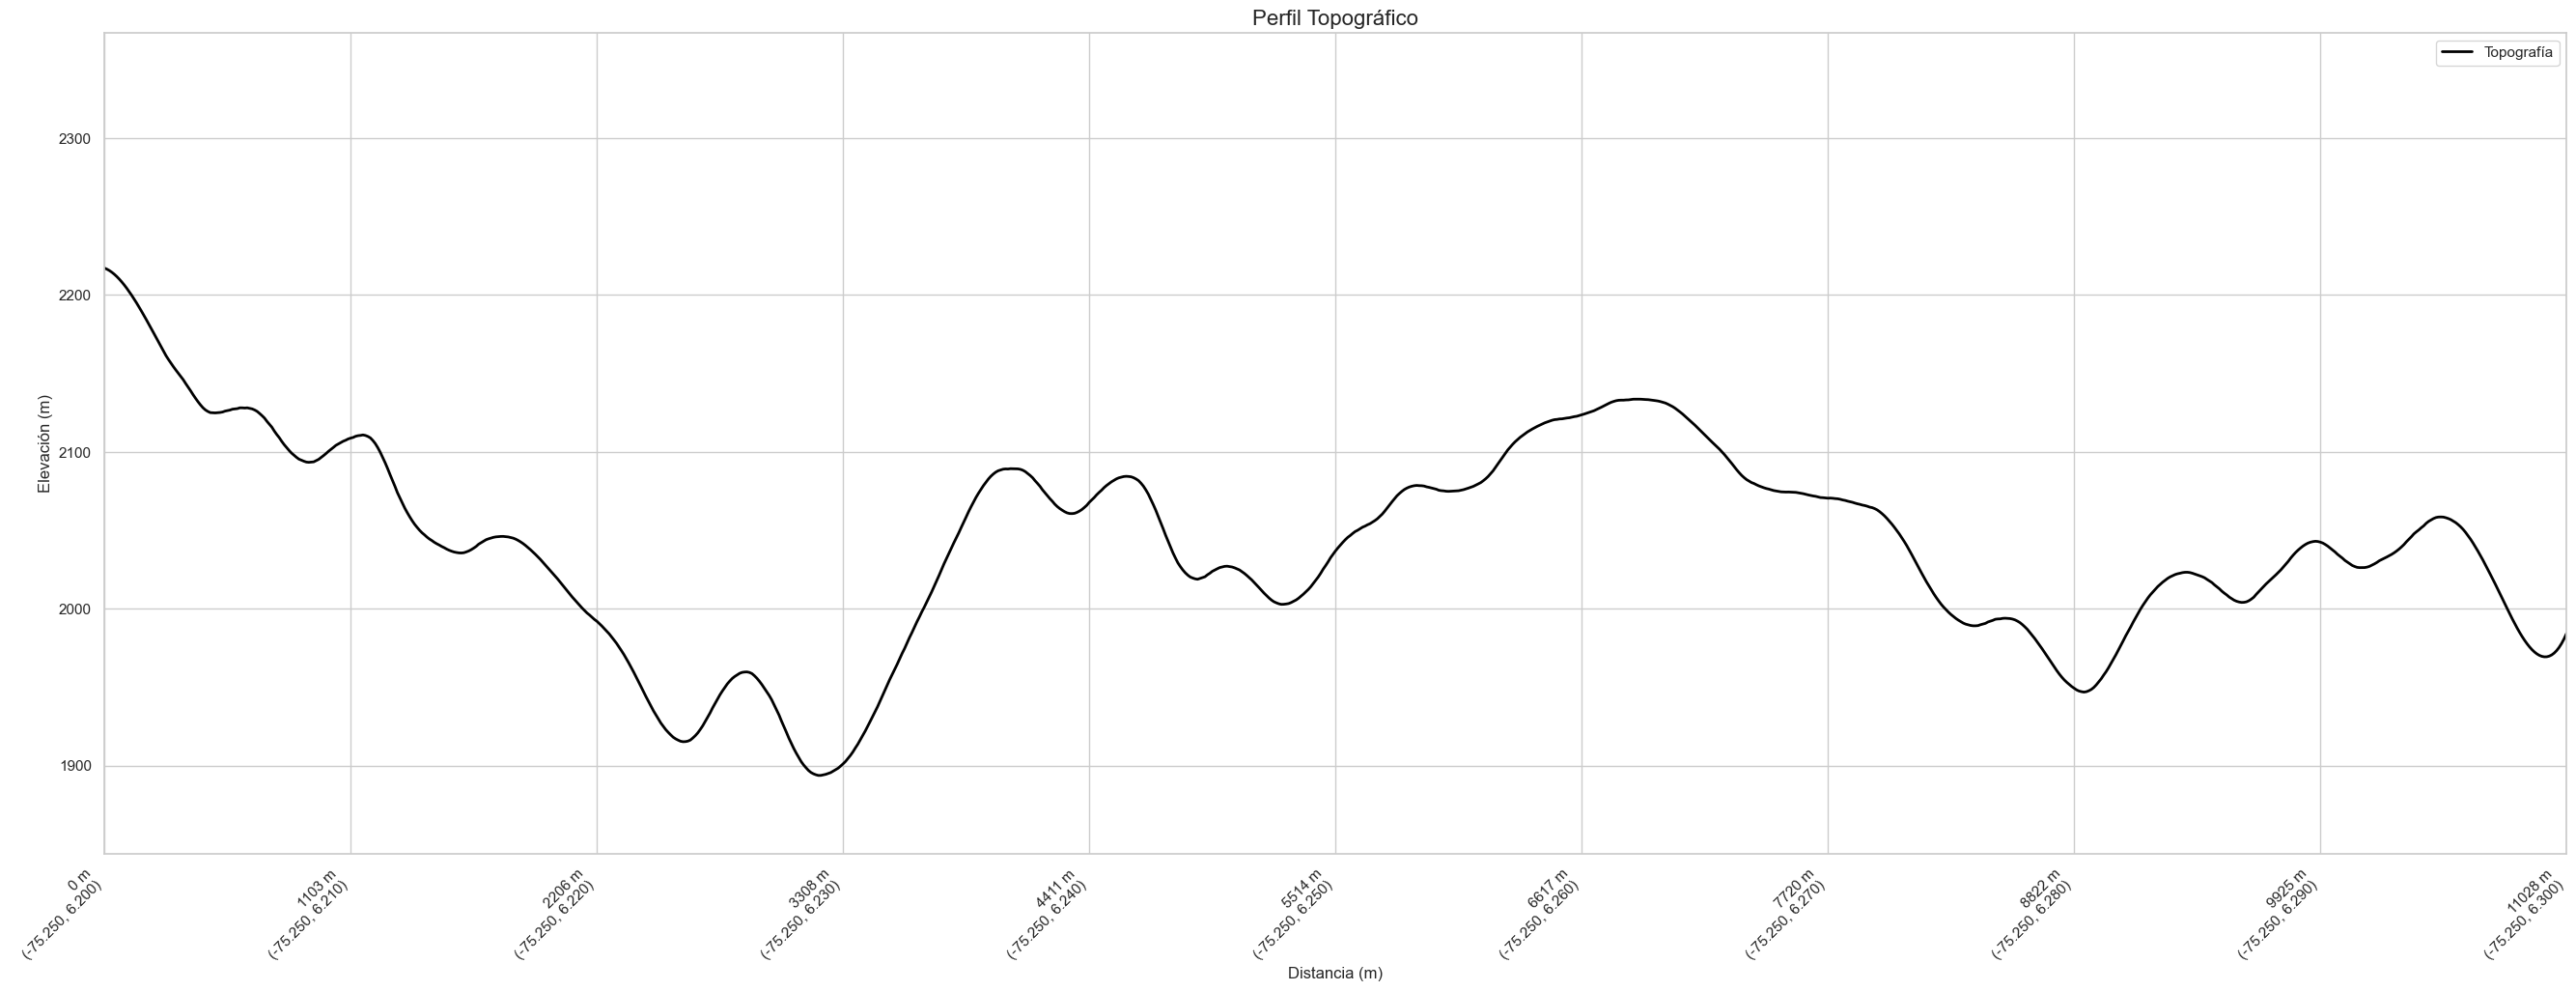

In [66]:
crear_perfil(dem_path, gdf_contour_path, angle=90)
#suavizado ventana 50, puedes ir probando 

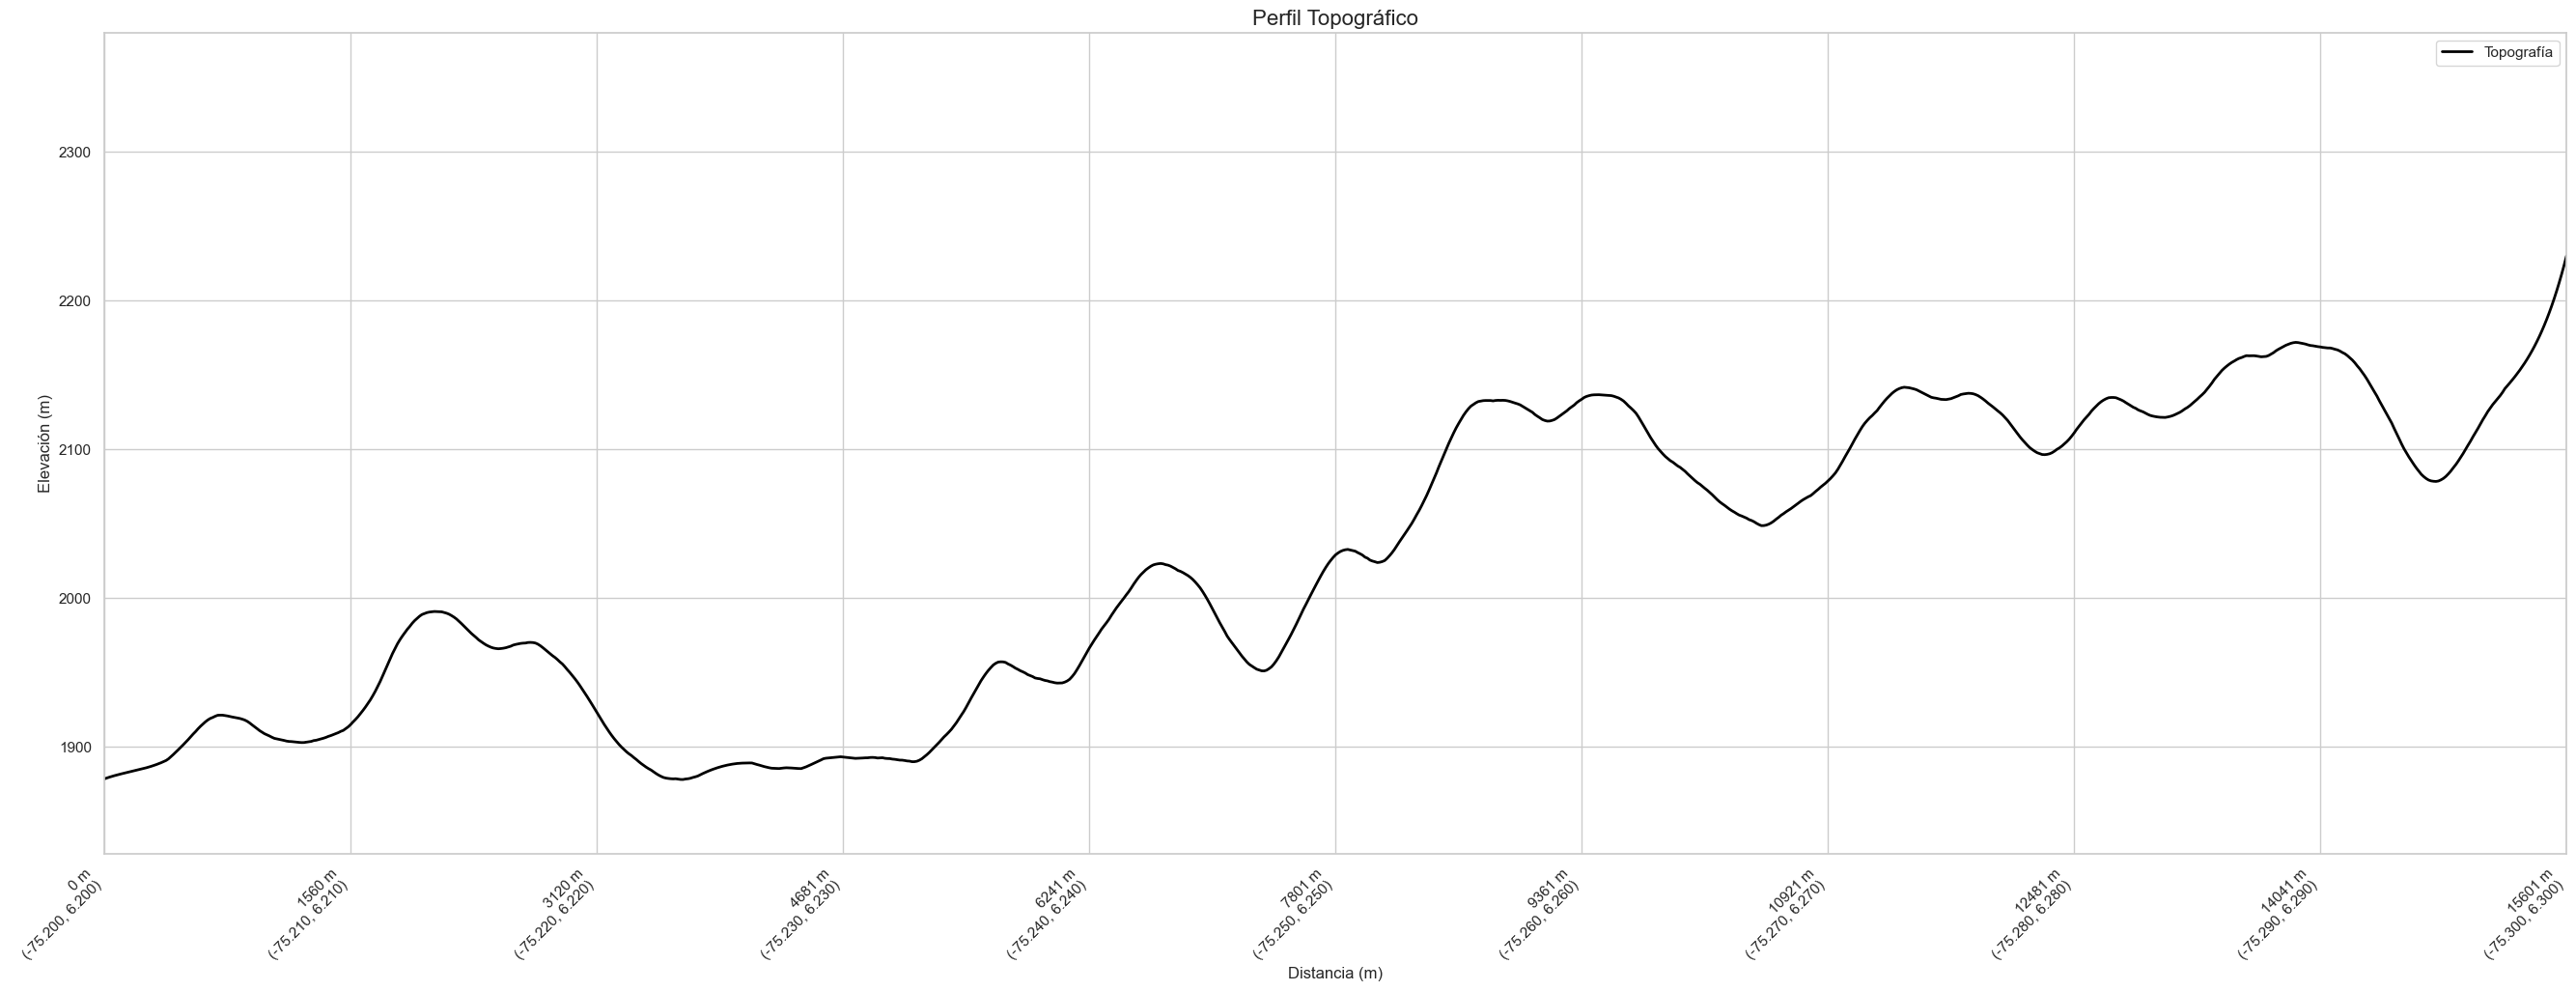

In [67]:
crear_perfil(dem_path, gdf_contour_path, angle=135,desx=4000)

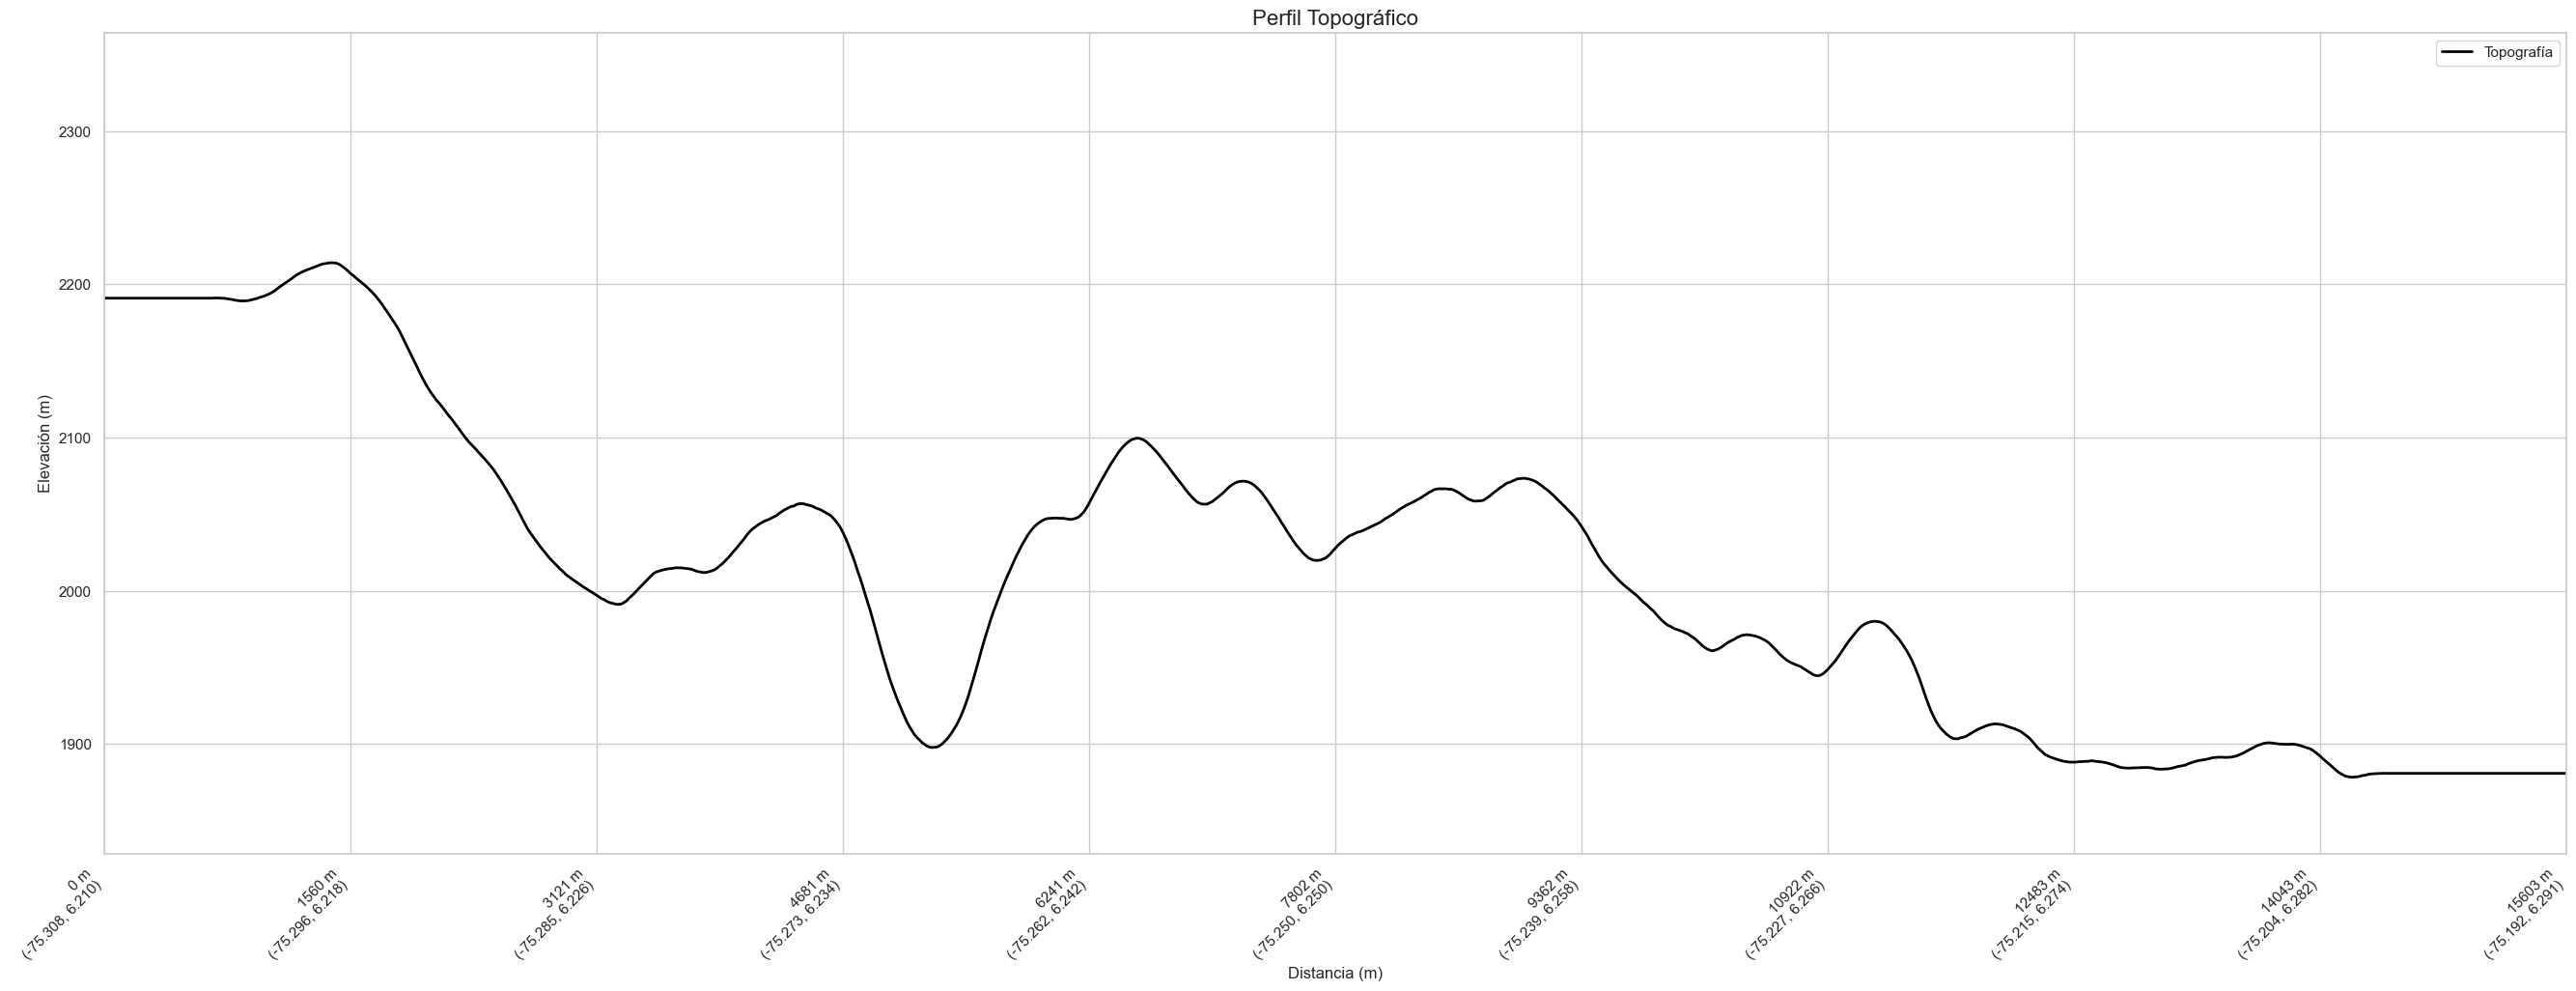

In [70]:
crear_perfil(dem_path, gdf_contour_path, angle=35,desy=7000)

In [52]:
###usa este si trabajas con coordenadas proyectadas
def crear_perfil(dem_path, gdf_contour_path, angle=0, num_points=1000,desy=0,desx=0):
    #numero de puntos que quieran es solo que entre mas mejor resolución
    gdf_contour = gpd.read_file(gdf_contour_path)
    #gdf_contour = gpd.read_file(gdf_contour_path).to_crs("EPSG:9377") para traerlo proyectado al crs que quieran    
    def create_line_by_angle_from_gdf(gdf, angle, desx=0, desy=0):
        total_bounds = gdf.total_bounds
        xmin, ymin, xmax, ymax = total_bounds
        mid_x, mid_y = (xmin + xmax) / 2, (ymin + ymax) / 2
        length = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
        angle_rad = np.deg2rad(angle)
        dx, dy = length * np.cos(angle_rad), length * np.sin(angle_rad)

        # Calculate starting and ending points within gdf bounds
        if angle in [0, 180]:
            start_point = (xmin + desx, mid_y + desy) if angle == 0 else (xmax + desx, mid_y + desy)
            end_point = (xmax + desx, mid_y + desy) if angle == 0 else (xmin + desx, mid_y + desy)
        elif angle in [90, 270]:
            start_point = (mid_x + desx, ymin + desy) if angle == 90 else (mid_x + desx, ymax + desy)
            end_point = (mid_x + desx, ymax + desy) if angle == 90 else (mid_x + desx, ymin + desy)
        else:
            start_point = (mid_x - dx / 2 + desx, mid_y - dy / 2 + desy)
            end_point = (mid_x + dx / 2 + desx, mid_y + dy / 2 + desy)

        return LineString([start_point, end_point])
    profile_line = create_line_by_angle_from_gdf(gdf_contour, angle)
    def extract_elevation_profile(dem_path, line_geom, num_points):
       
        with rasterio.open(dem_path) as dem:
            # Normalización de la línea interpolada usando la longitud total de la línea
            line_length = line_geom.length
            line_points = [line_geom.interpolate(i / num_points, normalized=True) for i in range(num_points + 1)]


            # Extraer coordenadas (x, y) de cada punto de la línea
            coords = [(point.x, point.y) for point in line_points]

            # Extraer los valores de elevación del DEM en las coordenadas
            elevations = np.array([val[0] for val in dem.sample(coords)])

            # Manejar los valores nulos o nodata
            mask = (elevations <= 0) | (elevations == dem.nodata)
            if np.any(mask):
                elevations[mask] = np.interp(
                    np.flatnonzero(mask), 
                    np.flatnonzero(~mask), 
                    elevations[~mask]
                )

        return elevations, coords

    elevations, coords = extract_elevation_profile(dem_path, profile_line, num_points)
    import matplotlib.cm as cm
    def plotear_perfil(elevations):
        # Calcular las distancias acumuladas para las coordenadas del perfil
        distances = [0]  # Inicia con 0 en la primera posición
        for i in range(1, len(coords)):
            dx = coords[i][0] - coords[i - 1][0]
            dy = coords[i][1] - coords[i - 1][1]
            distances.append(distances[-1] + np.sqrt(dx**2 + dy**2))

        # Suavizar las elevaciones con un filtro de Savitzky-Golay (opcional) mas ventana suaviza mas el ruido topografico
        #el grado del polinomio auyuda a no perder tanto detalle
        smoothed_elevations = savgol_filter(elevations, window_length=51, polyorder=3)

        sns.set_theme(style="whitegrid")
        fig, ax = plt.subplots(figsize=(30, 10))

        sns.lineplot(x=distances, y=smoothed_elevations, ax=ax, label='Topografía', color='black', linewidth=2)

        num_labels = 10  
        step = len(distances) // num_labels  
        xticks = distances[::step]  

        xticklabels = [
            f"{dist:.0f} m\n({coords[distances.index(dist)][0]:.3f}, {coords[distances.index(dist)][1]:.3f})"
            for dist in xticks
        ]

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels, rotation=45, ha='right')

        ax.set_xlim([0, distances[-1]])
        ax.set_ylim([min(smoothed_elevations) - 50, max(smoothed_elevations) + 150])

        ax.set_title('Perfil Topográfico', fontsize=16)
        ax.set_xlabel('Distancia (m)', fontsize=12)
        ax.set_ylabel('Elevación (m)', fontsize=12)
        plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
        #plt.savefig('plot_kink.png', dpi=300, format='png')
        plt.show()
    plotear_perfil(elevations)


In [49]:
#este es solo un ejemplo de la linea creada a partir de los bordes
# solo remplaza profile_line= por tu linea de corte